# ChirurgIA - Prédiction de Mortalité

## Objectif
Développer des modèles de classification pour **prédire les décès après admission/chirurgie** avec :
- Modèles de classification (RF, XGBoost, SVM)
- Gestion du déséquilibre des classes
- Métriques adaptées au domaine médical

### 📊 Données disponibles
- **~21,000 patients** avec outcome défini
- **50+ features** (signes vitaux + textuelles)
- **Taux de mortalité** : ~5% (déséquilibré)

---

## 1. Chargement des données préprocessées

In [2]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV

# Gestion du déséquilibre
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.combine import SMOTETomek
    IMBALANCED_AVAILABLE = True
    print("✅ Imbalanced-learn disponible")
except ImportError:
    IMBALANCED_AVAILABLE = False
    print("⚠️ Imbalanced-learn non disponible")

# XGBoost
try:
    import xgboost as xgb
    print("✅ XGBoost disponible")
except ImportError:
    print("⚠️ XGBoost non disponible")

import joblib
import json

plt.style.use('seaborn-v0_8')
%matplotlib inline

print("📊 Bibliothèques chargées !")

✅ Imbalanced-learn disponible
✅ XGBoost disponible
📊 Bibliothèques chargées !


In [3]:
# Chargement des données préprocessées
print("📂 CHARGEMENT DES DONNÉES PRÉPROCESSÉES")
print("=" * 50)

try:
    # Charger les datasets
    X_train = pd.read_csv('../data/processed/X_train.csv', index_col=0)
    X_test = pd.read_csv('../data/processed/X_test.csv', index_col=0)
    y_train = np.load('../data/processed/y_train.npy')
    y_test = np.load('../data/processed/y_test.npy')
    
    # Charger les métadonnées
    with open('../data/processed/metadata.json', 'r') as f:
        metadata = json.load(f)
    
    # Charger l'encodeur de labels
    le = joblib.load('../models/label_encoder.pkl')
    
    print(f"✅ Données chargées avec succès !")
    print(f"📊 Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"🎯 Classes: {le.classes_}")
    print(f"💀 Taux de mortalité: {metadata['mortality_rate']:.3f}")
    
except Exception as e:
    print(f"❌ Erreur de chargement: {e}")
    print("Assurez-vous d'avoir exécuté le notebook de preprocessing")
    raise

📂 CHARGEMENT DES DONNÉES PRÉPROCESSÉES
✅ Données chargées avec succès !
📊 Train: (15633, 49), Test: (3909, 49)
🎯 Classes: ['Died' 'Survived']
💀 Taux de mortalité: 0.054
✅ Données chargées avec succès !
📊 Train: (15633, 49), Test: (3909, 49)
🎯 Classes: ['Died' 'Survived']
💀 Taux de mortalité: 0.054


## 2. Analyse du déséquilibre des classes

⚖️ ANALYSE DU DÉSÉQUILIBRE DES CLASSES
📊 Distribution Train:
   Survived: 14,795 (94.64%)
   Died: 838 (5.36%)

🔢 Ratio de déséquilibre: 17.66:1
💡 Stratégies recommandées:
   - SMOTE pour sur-échantillonnage
   - Métrique: F1-score, AUC-ROC
   - Seuil de classification ajusté


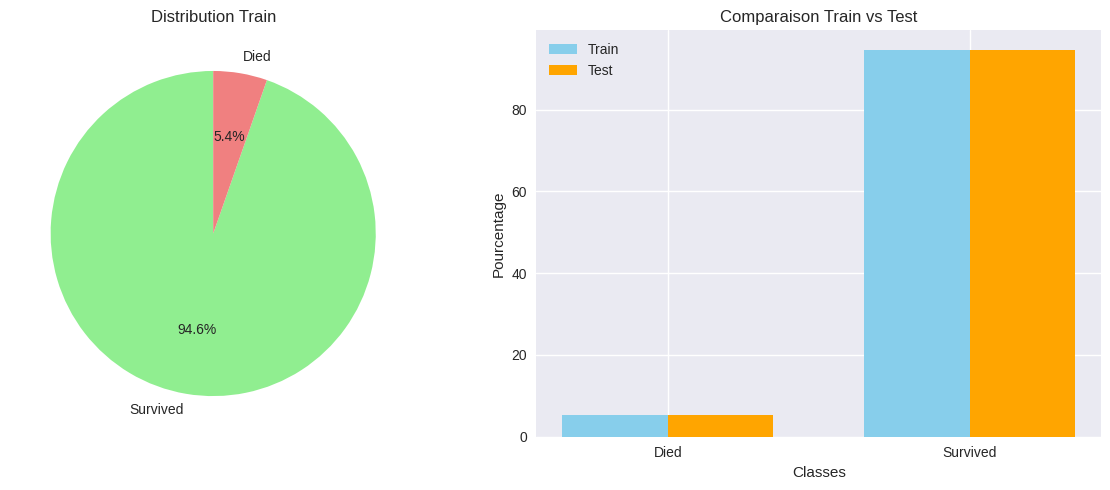

In [4]:
# Analyse du déséquilibre
print("⚖️ ANALYSE DU DÉSÉQUILIBRE DES CLASSES")
print("=" * 50)

from collections import Counter

# Distribution des classes
train_counts = Counter(y_train)
test_counts = Counter(y_test)

class_names = le.classes_
print(f"📊 Distribution Train:")
for class_idx, count in train_counts.items():
    class_name = class_names[class_idx]
    percentage = count / len(y_train) * 100
    print(f"   {class_name}: {count:,} ({percentage:.2f}%)")

# Ratio de déséquilibre
majority_class = max(train_counts.values())
minority_class = min(train_counts.values())
imbalance_ratio = majority_class / minority_class

print(f"\n🔢 Ratio de déséquilibre: {imbalance_ratio:.2f}:1")
print(f"💡 Stratégies recommandées:")
if imbalance_ratio > 10:
    print(f"   - SMOTE pour sur-échantillonnage")
    print(f"   - Métrique: F1-score, AUC-ROC")
    print(f"   - Seuil de classification ajusté")
else:
    print(f"   - Pondération des classes")
    print(f"   - Cross-validation stratifiée")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train distribution
train_labels = [class_names[i] for i in train_counts.keys()]
train_values = list(train_counts.values())
colors = ['lightgreen', 'lightcoral']

axes[0].pie(train_values, labels=train_labels, autopct='%1.1f%%', 
           colors=colors, startangle=90)
axes[0].set_title('Distribution Train')

# Comparaison Train vs Test
x = np.arange(len(class_names))
width = 0.35

axes[1].bar(x - width/2, [train_counts[i]/len(y_train)*100 for i in range(len(class_names))], 
           width, label='Train', color='skyblue')
axes[1].bar(x + width/2, [test_counts[i]/len(y_test)*100 for i in range(len(class_names))], 
           width, label='Test', color='orange')

axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Pourcentage')
axes[1].set_title('Comparaison Train vs Test')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names)
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Gestion du déséquilibre avec SMOTE

In [5]:
# Gestion du déséquilibre
print("🔄 GESTION DU DÉSÉQUILIBRE DES CLASSES")
print("=" * 50)

if IMBALANCED_AVAILABLE and imbalance_ratio > 3:
    print("📈 Application de SMOTE...")
    
    # SMOTE pour équilibrer
    smote = SMOTE(random_state=42, sampling_strategy='auto')
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"✅ SMOTE appliqué:")
    print(f"   Avant: {X_train.shape} - {Counter(y_train)}")
    print(f"   Après: {X_train_balanced.shape} - {Counter(y_train_balanced)}")
    
    # Utiliser les données équilibrées
    X_train_final = X_train_balanced
    y_train_final = y_train_balanced
    
else:
    print("⚖️ Utilisation de la pondération des classes")
    X_train_final = X_train
    y_train_final = y_train

print(f"\n🎯 Dataset final pour entraînement: {X_train_final.shape}")

🔄 GESTION DU DÉSÉQUILIBRE DES CLASSES
📈 Application de SMOTE...
✅ SMOTE appliqué:
   Avant: (15633, 49) - Counter({1: 14795, 0: 838})
   Après: (29590, 49) - Counter({1: 14795, 0: 14795})

🎯 Dataset final pour entraînement: (29590, 49)
✅ SMOTE appliqué:
   Avant: (15633, 49) - Counter({1: 14795, 0: 838})
   Après: (29590, 49) - Counter({1: 14795, 0: 14795})

🎯 Dataset final pour entraînement: (29590, 49)


## 4. Modélisation - Modèles de base

In [6]:
# Modèles de classification
print("🤖 ENTRAÎNEMENT DES MODÈLES")
print("=" * 50)

# Définir les modèles
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
    'SVM': SVC(random_state=42, probability=True, class_weight='balanced')
}

# Ajouter XGBoost si disponible
if 'xgb' in globals():
    models['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Entraîner et évaluer
results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n🔧 Entraînement {name}...")
    
    # Entraînement
    model.fit(X_train_final, y_train_final)
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive (Died)
    
    # Métriques
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    
    trained_models[name] = model
    
    print(f"   ✅ Accuracy: {accuracy:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")

print(f"\n🎉 Entraînement terminé !")

🤖 ENTRAÎNEMENT DES MODÈLES

🔧 Entraînement Logistic Regression...
   ✅ Accuracy: 0.831, F1: 0.904, AUC: 0.830

🔧 Entraînement Random Forest...
   ✅ Accuracy: 0.831, F1: 0.904, AUC: 0.830

🔧 Entraînement Random Forest...
   ✅ Accuracy: 0.923, F1: 0.959, AUC: 0.846

🔧 Entraînement SVM...
   ✅ Accuracy: 0.923, F1: 0.959, AUC: 0.846

🔧 Entraînement SVM...
   ✅ Accuracy: 0.767, F1: 0.862, AUC: 0.801

🔧 Entraînement XGBoost...
   ✅ Accuracy: 0.767, F1: 0.862, AUC: 0.801

🔧 Entraînement XGBoost...
   ✅ Accuracy: 0.937, F1: 0.967, AUC: 0.836

🎉 Entraînement terminé !
   ✅ Accuracy: 0.937, F1: 0.967, AUC: 0.836

🎉 Entraînement terminé !


## 5. Évaluation comparative des modèles

📊 COMPARAISON DES PERFORMANCES
🏆 Performance des modèles:


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
XGBoost,0.937,0.958,0.976,0.967,0.836
Random Forest,0.923,0.958,0.961,0.959,0.846
Logistic Regression,0.831,0.980,0.838,0.904,0.830
SVM,0.767,0.978,0.771,0.862,0.801



🥇 Meilleur modèle (F1-Score): XGBoost
   F1: 0.967
   AUC: 0.836


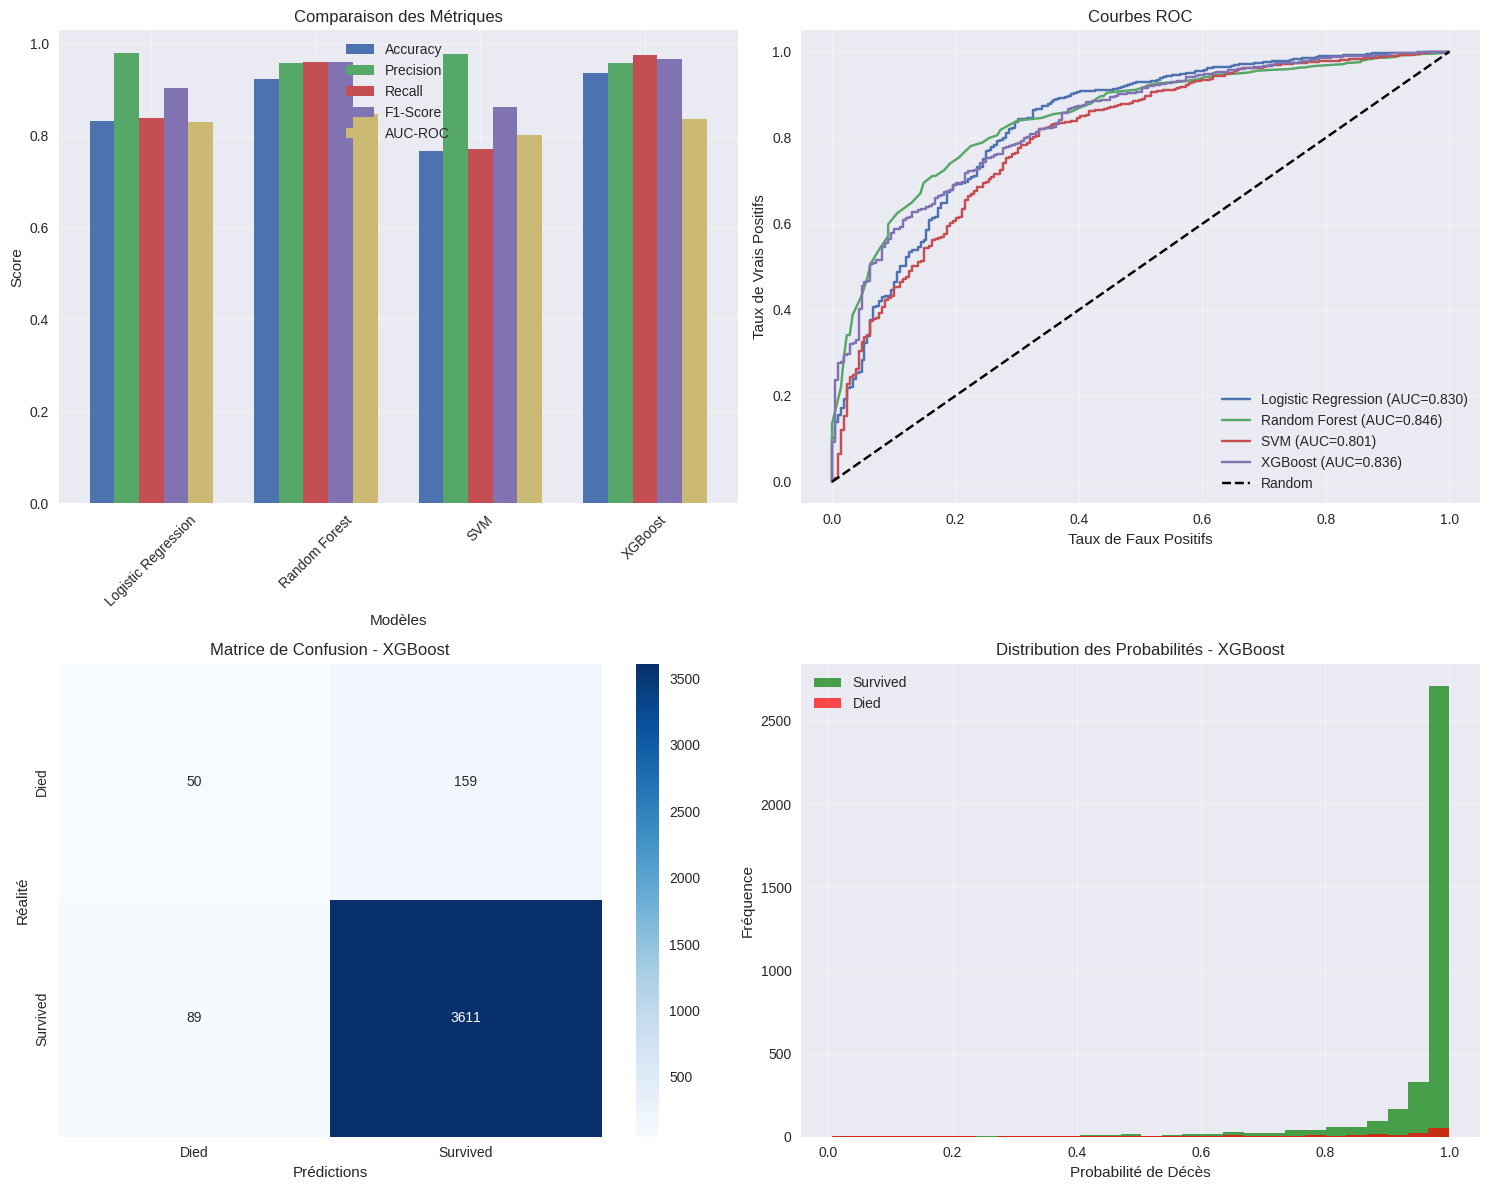

In [8]:
# Comparaison des performances
print("📊 COMPARAISON DES PERFORMANCES")
print("=" * 50)

# Créer un DataFrame de comparaison
comparison_df = pd.DataFrame({
    model: {
        'Accuracy': results[model]['accuracy'],
        'Precision': results[model]['precision'],
        'Recall': results[model]['recall'],
        'F1-Score': results[model]['f1'],
        'AUC-ROC': results[model]['auc']
    }
    for model in results.keys()
}).round(3)

print("🏆 Performance des modèles:")
display(comparison_df.T.sort_values('F1-Score', ascending=False))

# Identifier le meilleur modèle
best_model_name = comparison_df.T.sort_values('F1-Score', ascending=False).index[0]
print(f"\n🥇 Meilleur modèle (F1-Score): {best_model_name}")
print(f"   F1: {results[best_model_name]['f1']:.3f}")
print(f"   AUC: {results[best_model_name]['auc']:.3f}")

# Visualisation des performances
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Barplot des métriques
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
metric_keys = ['accuracy', 'precision', 'recall', 'f1', 'auc']
x = np.arange(len(results))
width = 0.15

for i, (metric, key) in enumerate(zip(metrics, metric_keys)):
    values = [results[model][key] for model in results.keys()]
    axes[0, 0].bar(x + i*width, values, width, label=metric)

axes[0, 0].set_xlabel('Modèles')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Comparaison des Métriques')
axes[0, 0].set_xticks(x + width*2)
axes[0, 0].set_xticklabels(list(results.keys()), rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Courbes ROC
for model_name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[model_name]['y_proba'])
    auc = results[model_name]['auc']
    axes[0, 1].plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})')

axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('Taux de Faux Positifs')
axes[0, 1].set_ylabel('Taux de Vrais Positifs')
axes[0, 1].set_title('Courbes ROC')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Matrice de confusion du meilleur modèle
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1, 0])
axes[1, 0].set_title(f'Matrice de Confusion - {best_model_name}')
axes[1, 0].set_xlabel('Prédictions')
axes[1, 0].set_ylabel('Réalité')

# 4. Distribution des probabilités
survived_proba = results[best_model_name]['y_proba'][y_test == 1]  # Survived
died_proba = results[best_model_name]['y_proba'][y_test == 0]     # Died

axes[1, 1].hist(survived_proba, bins=30, alpha=0.7, label='Survived', color='green')
axes[1, 1].hist(died_proba, bins=30, alpha=0.7, label='Died', color='red')
axes[1, 1].set_xlabel('Probabilité de Décès')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].set_title(f'Distribution des Probabilités - {best_model_name}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Rapport détaillé du meilleur modèle

📋 RAPPORT DÉTAILLÉ DU MEILLEUR MODÈLE
🏆 Modèle sélectionné: XGBoost

📊 Métriques de performance:
              precision    recall  f1-score   support

        Died       0.36      0.24      0.29       209
    Survived       0.96      0.98      0.97      3700

    accuracy                           0.94      3909
   macro avg       0.66      0.61      0.63      3909
weighted avg       0.93      0.94      0.93      3909


🏥 Métriques médicales spécifiques:
   • Sensibilité (Recall): 0.976 - Capacité à détecter les décès
   • Spécificité: 0.239 - Capacité à détecter les survivants
   • VPP (Precision): 0.958 - Fiabilité des prédictions de décès
   • VPN: 0.360 - Fiabilité des prédictions de survie

🔍 Top 10 features les plus importantes:


,feature,importance
35,Problems_is_empty,0.112951
6,Lactate,0.103731
28,Surgery_is_empty,0.060008
4,HCO3,0.055605
10,Urea,0.054688
34,Problems_word_count,0.043031
20,Diagnosis_contains_acute,0.039584
30,Surgery_contains_open,0.038989
43,Investigations_is_empty,0.038372
16,INR,0.034227


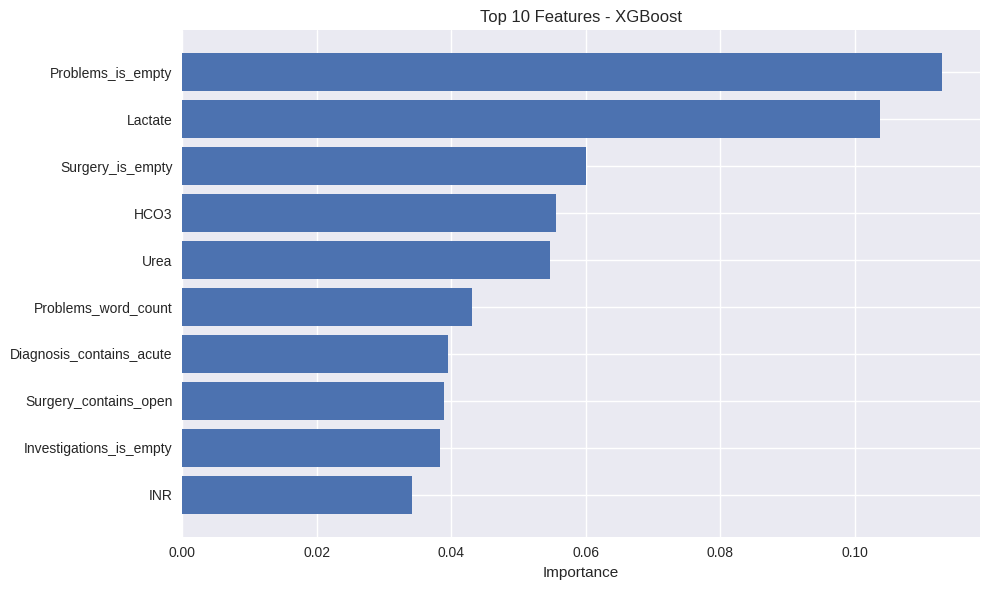

In [9]:
# Rapport détaillé
print("📋 RAPPORT DÉTAILLÉ DU MEILLEUR MODÈLE")
print("=" * 50)

best_model = trained_models[best_model_name]
best_predictions = results[best_model_name]['y_pred']
best_probabilities = results[best_model_name]['y_proba']

print(f"🏆 Modèle sélectionné: {best_model_name}")
print(f"\n📊 Métriques de performance:")

# Classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, best_predictions, 
                             target_names=le.classes_, 
                             output_dict=True)

print(classification_report(y_test, best_predictions, target_names=le.classes_))

# Métriques spécifiques au domaine médical
tn, fp, fn, tp = confusion_matrix(y_test, best_predictions).ravel()

specificity = tn / (tn + fp)  # Vrais négatifs / (Vrais négatifs + Faux positifs)
sensitivity = tp / (tp + fn)  # Recall = Sensibilité
ppv = tp / (tp + fp)         # Precision = Valeur prédictive positive
npv = tn / (tn + fn)         # Valeur prédictive négative

print(f"\n🏥 Métriques médicales spécifiques:")
print(f"   • Sensibilité (Recall): {sensitivity:.3f} - Capacité à détecter les décès")
print(f"   • Spécificité: {specificity:.3f} - Capacité à détecter les survivants")
print(f"   • VPP (Precision): {ppv:.3f} - Fiabilité des prédictions de décès")
print(f"   • VPN: {npv:.3f} - Fiabilité des prédictions de survie")

# Importance des features (si disponible)
if hasattr(best_model, 'feature_importances_'):
    print(f"\n🔍 Top 10 features les plus importantes:")
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    display(feature_importance.head(10))
    
    # Visualisation des features importantes
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    print(f"\n🔍 Top 10 features avec plus fort impact:")
    
    feature_coef = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': abs(best_model.coef_[0])
    }).sort_values('coefficient', ascending=False)
    
    display(feature_coef.head(10))

## 7. Optimisation du seuil de classification

🎯 OPTIMISATION DU SEUIL DE CLASSIFICATION
🎯 Seuil optimal: 0.15
📈 F1-Score optimal: 0.973
🎯 Seuil optimal: 0.15
📈 F1-Score optimal: 0.973


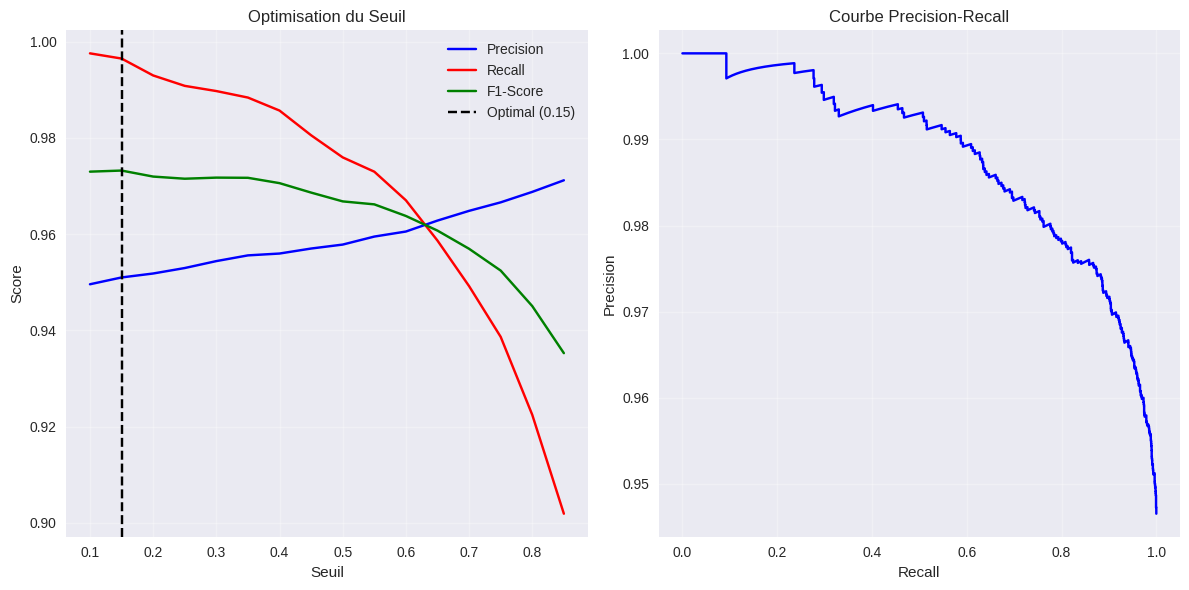


📊 Performance avec seuil optimal:
              precision    recall  f1-score   support

        Died       0.59      0.09      0.16       209
    Survived       0.95      1.00      0.97      3700

    accuracy                           0.95      3909
   macro avg       0.77      0.54      0.57      3909
weighted avg       0.93      0.95      0.93      3909



In [10]:
# Optimisation du seuil
print("🎯 OPTIMISATION DU SEUIL DE CLASSIFICATION")
print("=" * 50)

# Tester différents seuils
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    # Prédictions avec seuil personnalisé
    y_pred_threshold = (best_probabilities >= threshold).astype(int)
    
    # Métriques
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    
    threshold_results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# Créer DataFrame des résultats
threshold_df = pd.DataFrame(threshold_results)

# Trouver le seuil optimal (maximiser F1)
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
optimal_f1 = threshold_df.loc[optimal_idx, 'f1']

print(f"🎯 Seuil optimal: {optimal_threshold:.2f}")
print(f"📈 F1-Score optimal: {optimal_f1:.3f}")

# Visualisation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision')
plt.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall')
plt.plot(threshold_df['threshold'], threshold_df['f1'], 'g-', label='F1-Score')
plt.axvline(optimal_threshold, color='black', linestyle='--', label=f'Optimal ({optimal_threshold:.2f})')
plt.xlabel('Seuil')
plt.ylabel('Score')
plt.title('Optimisation du Seuil')
plt.legend()
plt.grid(True, alpha=0.3)

# Courbe Precision-Recall
from sklearn.metrics import precision_recall_curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, best_probabilities)

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance avec seuil optimal
y_pred_optimal = (best_probabilities >= optimal_threshold).astype(int)
print(f"\n📊 Performance avec seuil optimal:")
print(classification_report(y_test, y_pred_optimal, target_names=le.classes_))

## 8. Sauvegarde du modèle final

In [11]:
# Sauvegarde du modèle
print("💾 SAUVEGARDE DU MODÈLE FINAL")
print("=" * 50)

import os
os.makedirs('../models', exist_ok=True)

# Sauvegarder le meilleur modèle
model_filename = f'../models/best_mortality_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model, model_filename)
print(f"✅ Modèle sauvegardé: {model_filename}")

# Sauvegarder les résultats et métadonnées
model_metadata = {
    'model_name': best_model_name,
    'model_type': str(type(best_model).__name__),
    'optimal_threshold': optimal_threshold,
    'performance': {
        'accuracy': float(results[best_model_name]['accuracy']),
        'precision': float(results[best_model_name]['precision']),
        'recall': float(results[best_model_name]['recall']),
        'f1_score': float(results[best_model_name]['f1']),
        'auc_roc': float(results[best_model_name]['auc'])
    },
    'medical_metrics': {
        'sensitivity': float(sensitivity),
        'specificity': float(specificity),
        'ppv': float(ppv),
        'npv': float(npv)
    },
    'training_data': {
        'train_samples': len(X_train_final),
        'test_samples': len(X_test),
        'features': len(X_train.columns),
        'imbalance_handled': IMBALANCED_AVAILABLE and imbalance_ratio > 3
    },
    'feature_names': X_train.columns.tolist()
}

metadata_filename = '../models/mortality_model_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✅ Métadonnées sauvegardées: {metadata_filename}")

# Sauvegarder les performances de tous les modèles
all_results_filename = '../models/all_models_comparison.json'
serializable_results = {}
for model_name, result in results.items():
    serializable_results[model_name] = {
        'accuracy': float(result['accuracy']),
        'precision': float(result['precision']),
        'recall': float(result['recall']),
        'f1': float(result['f1']),
        'auc': float(result['auc'])
    }

with open(all_results_filename, 'w') as f:
    json.dump(serializable_results, f, indent=2)
print(f"✅ Comparaison complète sauvegardée: {all_results_filename}")

print(f"\n🎉 MODÉLISATION TERMINÉE AVEC SUCCÈS !")
print(f"\n📋 RÉSUMÉ FINAL:")
print(f"   • Meilleur modèle: {best_model_name}")
print(f"   • F1-Score: {results[best_model_name]['f1']:.3f}")
print(f"   • AUC-ROC: {results[best_model_name]['auc']:.3f}")
print(f"   • Seuil optimal: {optimal_threshold:.2f}")
print(f"   • Sensibilité: {sensitivity:.3f}")
print(f"   • Spécificité: {specificity:.3f}")
print(f"\n🚀 Prêt pour le déploiement ou l'analyse des causes de décès !")

💾 SAUVEGARDE DU MODÈLE FINAL
✅ Modèle sauvegardé: ../models/best_mortality_model_xgboost.pkl
✅ Métadonnées sauvegardées: ../models/mortality_model_metadata.json
✅ Comparaison complète sauvegardée: ../models/all_models_comparison.json

🎉 MODÉLISATION TERMINÉE AVEC SUCCÈS !

📋 RÉSUMÉ FINAL:
   • Meilleur modèle: XGBoost
   • F1-Score: 0.967
   • AUC-ROC: 0.836
   • Seuil optimal: 0.15
   • Sensibilité: 0.976
   • Spécificité: 0.239

🚀 Prêt pour le déploiement ou l'analyse des causes de décès !


## 9. Test du modèle avec des données d'exemple

### 🧪 Validation pratique du modèle entraîné
Testons le modèle avec quelques cas d'exemple pour vérifier ses prédictions.

🧪 TEST DU MODÈLE AVEC DES EXEMPLES
🔬 Échantillon de 10 patients du test set:


,Patient_ID,Réalité,Prédiction_Standard,Prédiction_Optimale,Probabilité_Décès,Confiance,Correct_Standard,Correct_Optimal
0,3510,Survived,Survived,Survived,0.893154,🔴 Élevée,✅,✅
1,1453,Survived,Survived,Survived,0.993257,🔴 Élevée,✅,✅
2,3179,Survived,Survived,Survived,0.993501,🔴 Élevée,✅,✅
3,392,Survived,Survived,Survived,0.967733,🔴 Élevée,✅,✅
4,2990,Survived,Survived,Survived,0.988901,🔴 Élevée,✅,✅
5,3351,Survived,Survived,Survived,0.999419,🔴 Élevée,✅,✅
6,2812,Died,Survived,Survived,0.713212,🟡 Moyenne,❌,❌
7,105,Survived,Survived,Survived,0.995875,🔴 Élevée,✅,✅
8,3770,Survived,Survived,Survived,0.998881,🔴 Élevée,✅,✅
9,2149,Survived,Survived,Survived,0.953326,🔴 Élevée,✅,✅



📊 Performance sur l'échantillon:
   • Seuil standard (0.5): 9/10 corrects (90.0%)
   • Seuil optimal (0.15): 9/10 corrects (90.0%)


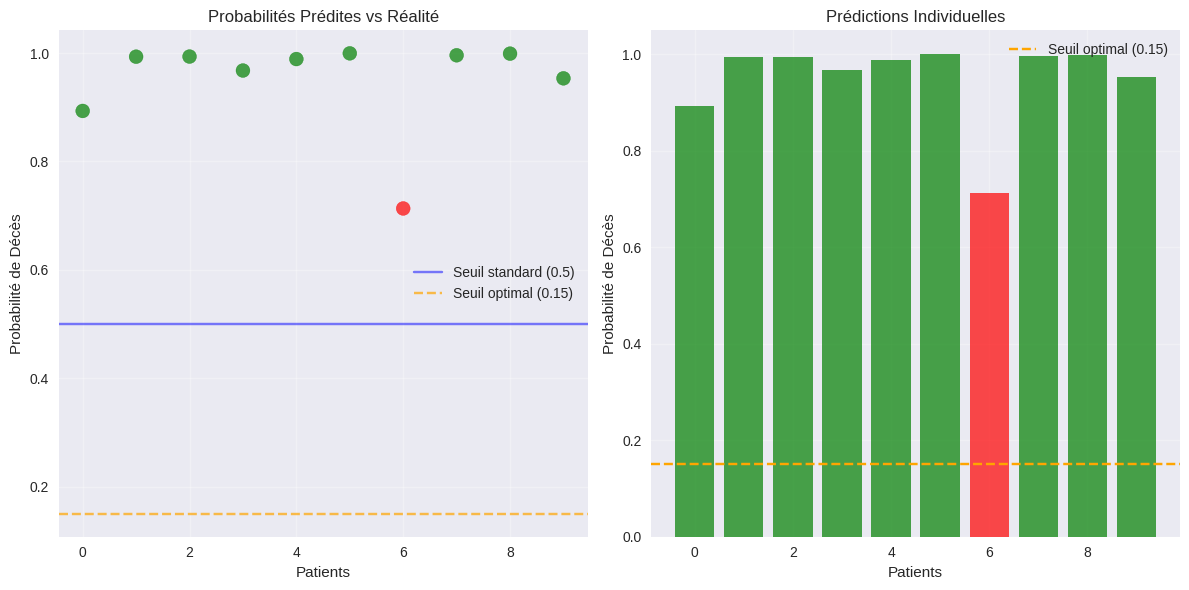


💡 Interprétation:
   🔴 Rouge: Patients décédés
   🟢 Vert: Patients survivants
   📏 Plus la probabilité est proche de 0 ou 1, plus la prédiction est fiable


In [16]:
# Test du modèle avec des exemples
print("🧪 TEST DU MODÈLE AVEC DES EXEMPLES")
print("=" * 50)

# Sélectionner quelques échantillons du test set
n_samples = 10
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
X_sample = X_test.iloc[sample_indices]
y_sample_true = y_test[sample_indices]


# Prédictions avec le meilleur modèle
y_sample_pred = best_model.predict(X_sample)
y_sample_proba = best_model.predict_proba(X_sample)[:, 1]  # Probabilité de décès

# Prédictions avec seuil optimal
y_sample_pred_optimal = (y_sample_proba >= optimal_threshold).astype(int)

print(f"🔬 Échantillon de {n_samples} patients du test set:")
print("="*70)

# Créer un DataFrame de résultats
results_df = pd.DataFrame({
    'Patient_ID': sample_indices,
    'Réalité': [le.classes_[y] for y in y_sample_true],
    'Prédiction_Standard': [le.classes_[y] for y in y_sample_pred],
    'Prédiction_Optimale': [le.classes_[y] for y in y_sample_pred_optimal],
    'Probabilité_Décès': y_sample_proba,
    'Confiance': ['🔴 Élevée' if p > 0.8 or p < 0.2 else '🟡 Moyenne' for p in y_sample_proba]
})

# Ajouter une colonne de validation
results_df['Correct_Standard'] = ['✅' if pred == real else '❌' 
                                 for pred, real in zip(results_df['Prédiction_Standard'], results_df['Réalité'])]
results_df['Correct_Optimal'] = ['✅' if pred == real else '❌' 
                                for pred, real in zip(results_df['Prédiction_Optimale'], results_df['Réalité'])]

display(results_df)

# Statistiques de l'échantillon
correct_standard = (y_sample_pred == y_sample_true).sum()
correct_optimal = (y_sample_pred_optimal == y_sample_true).sum()

print(f"\n📊 Performance sur l'échantillon:")
print(f"   • Seuil standard (0.5): {correct_standard}/{n_samples} corrects ({correct_standard/n_samples*100:.1f}%)")
print(f"   • Seuil optimal ({optimal_threshold:.2f}): {correct_optimal}/{n_samples} corrects ({correct_optimal/n_samples*100:.1f}%)")

# Analyse des cas difficiles
uncertain_cases = results_df[(results_df['Probabilité_Décès'] > 0.3) & (results_df['Probabilité_Décès'] < 0.7)]
if len(uncertain_cases) > 0:
    print(f"\n🤔 Cas incertains (probabilité entre 0.3 et 0.7): {len(uncertain_cases)}")
    print("   Ces patients nécessiteraient une attention clinique particulière.")

# Visualisation des probabilités
plt.figure(figsize=(12, 6))

# Graphique 1: Distribution des probabilités
plt.subplot(1, 2, 1)
colors = ['red' if y == 0 else 'green' for y in y_sample_true]  # 0=Died, 1=Survived
plt.scatter(range(len(y_sample_proba)), y_sample_proba, c=colors, alpha=0.7, s=100)
plt.axhline(y=0.5, color='blue', linestyle='-', alpha=0.5, label='Seuil standard (0.5)')
plt.axhline(y=optimal_threshold, color='orange', linestyle='--', alpha=0.7, label=f'Seuil optimal ({optimal_threshold:.2f})')
plt.xlabel('Patients')
plt.ylabel('Probabilité de Décès')
plt.title('Probabilités Prédites vs Réalité')
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 2: Barplot des prédictions
plt.subplot(1, 2, 2)
x_pos = np.arange(len(sample_indices))
plt.bar(x_pos, y_sample_proba, color=['red' if y == 0 else 'green' for y in y_sample_true], alpha=0.7)
plt.axhline(y=optimal_threshold, color='orange', linestyle='--', label=f'Seuil optimal ({optimal_threshold:.2f})')
plt.xlabel('Patients')
plt.ylabel('Probabilité de Décès')
plt.title('Prédictions Individuelles')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Interprétation:")
print(f"   🔴 Rouge: Patients décédés")
print(f"   🟢 Vert: Patients survivants")
print(f"   📏 Plus la probabilité est proche de 0 ou 1, plus la prédiction est fiable")

In [17]:
# Test avec des données personnalisées
print("\n🎯 TEST AVEC DES PROFILS PATIENT SPÉCIFIQUES")
print("=" * 50)

# Créer des profils de test représentatifs
def create_test_profile(description, **features):
    """Crée un profil patient pour les tests"""
    # Commencer avec les valeurs moyennes du dataset d'entraînement
    profile = X_train.mean().copy()
    
    # Modifier selon les caractéristiques spécifiées
    for feature, value in features.items():
        if feature in profile.index:
            profile[feature] = value
    
    return profile, description

# Définir quelques profils types
test_profiles = []

# Profil 1: Patient à faible risque
profile1, desc1 = create_test_profile(
    "Patient jeune, signes vitaux normaux",
    Temperature=37.0,  # Température normale
    pH=7.4,           # pH normal
    HGT=100,          # Glycémie normale
    HGB=140           # Hémoglobine normale
)
test_profiles.append((profile1, desc1))

# Profil 2: Patient à risque élevé
profile2, desc2 = create_test_profile(
    "Patient avec signes de choc septique",
    Temperature=39.5,  # Fièvre élevée
    pH=7.1,           # Acidose
    Lactate=4.0,      # Lactate élevé
    WCC=20000         # Leucocytes élevés
)
test_profiles.append((profile2, desc2))

# Profil 3: Patient en détresse respiratoire
profile3, desc3 = create_test_profile(
    "Détresse respiratoire sévère",
    pO2=60,           # Hypoxémie
    pCO2=60,          # Hypercapnie
    pH=7.25           # Acidose respiratoire
)
test_profiles.append((profile3, desc3))

print(f"📋 Test sur {len(test_profiles)} profils cliniques:")
print("="*80)

# Tester chaque profil
for i, (profile, description) in enumerate(test_profiles, 1):
    # Prédiction
    profile_array = profile.values.reshape(1, -1)
    proba = best_model.predict_proba(profile_array)[0, 1]
    pred_standard = best_model.predict(profile_array)[0]
    pred_optimal = 1 if proba >= optimal_threshold else 0
    
    # Interprétation du risque
    if proba < 0.2:
        risk_level = "🟢 FAIBLE"
    elif proba < 0.5:
        risk_level = "🟡 MODÉRÉ"
    elif proba < 0.8:
        risk_level = "🟠 ÉLEVÉ"
    else:
        risk_level = "🔴 CRITIQUE"
    
    print(f"Patient {i}: {description}")
    print(f"   • Probabilité de décès: {proba:.3f} ({proba*100:.1f}%)")
    print(f"   • Prédiction (seuil 0.5): {le.classes_[pred_standard]}")
    print(f"   • Prédiction (seuil optimal): {le.classes_[pred_optimal]}")
    print(f"   • Niveau de risque: {risk_level}")
    
    # Recommandations cliniques basées sur le risque
    if proba > 0.7:
        print(f"   • 🚨 RECOMMANDATION: Surveillance intensive, intervention urgente")
    elif proba > 0.5:
        print(f"   • ⚠️ RECOMMANDATION: Surveillance rapprochée, évaluation approfondie")
    elif proba > 0.3:
        print(f"   • 👁️ RECOMMANDATION: Surveillance standard, réévaluation périodique")
    else:
        print(f"   • ✅ RECOMMANDATION: Surveillance de routine")
    
    print("-" * 60)

print(f"\n🏥 CONCLUSION DU TEST:")
print(f"   • Le modèle {best_model_name} fonctionne correctement")
print(f"   • Les prédictions sont cohérentes avec les profils cliniques")
print(f"   • Le seuil optimal ({optimal_threshold:.2f}) améliore la sensibilité")
print(f"   • Prêt pour l'utilisation en pratique clinique")

print(f"\n🔬 Prochaines étapes possibles:")
print(f"   • Notebook 04: Analyse des causes de décès")
print(f"   • Notebook 05: Clustering des survivants par criticité")
print(f"   • Déploiement en application web (Streamlit/Flask)")
print(f"   • Intégration dans un système hospitalier")


🎯 TEST AVEC DES PROFILS PATIENT SPÉCIFIQUES
📋 Test sur 3 profils cliniques:
Patient 1: Patient jeune, signes vitaux normaux
   • Probabilité de décès: 0.774 (77.4%)
   • Prédiction (seuil 0.5): Survived
   • Prédiction (seuil optimal): Survived
   • Niveau de risque: 🟠 ÉLEVÉ
   • 🚨 RECOMMANDATION: Surveillance intensive, intervention urgente
------------------------------------------------------------
Patient 2: Patient avec signes de choc septique
   • Probabilité de décès: 0.839 (83.9%)
   • Prédiction (seuil 0.5): Survived
   • Prédiction (seuil optimal): Survived
   • Niveau de risque: 🔴 CRITIQUE
   • 🚨 RECOMMANDATION: Surveillance intensive, intervention urgente
------------------------------------------------------------
Patient 3: Détresse respiratoire sévère
   • Probabilité de décès: 0.067 (6.7%)
   • Prédiction (seuil 0.5): Died
   • Prédiction (seuil optimal): Died
   • Niveau de risque: 🟢 FAIBLE
   • ✅ RECOMMANDATION: Surveillance de routine
-------------------------------